# Mapping and EDA for Open PV Data

In [3]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import sqlite3
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# The Data:

I've been cleaning the data in another notebook, I'll read it in here from my local db.

The cleaning process isn't done yet, but I can still do some EDA.

I'm also in the process of getting a lot of solar insolation and weather data, which I presume will have an effect on my EDA and I'll want to look into.

In [4]:
conn = sqlite3.Connection("./capstone.sqlite")

df = pd.read_sql("SELECT * FROM open_pv_clean", con=conn)

In [57]:
# still many nulls, working on imputing and cleaning.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020298 entries, 0 to 1020297
Data columns (total 33 columns):
level_0                        1020298 non-null int64
index                          1020298 non-null int64
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null float64
city                           1020231 non-null object
utility_clean                  1020298 non-null object
tech

# Data Dictionary:

This data corresponds to individual photovoltaic solar power installations.

 - **state**: state where the installation is located.
 - **date_installed**: date when installation was installed.
 - **incentive_prog_names**: government incentive program that helped fund the solar installation.
 - **type**: UIR or PIR, ways of measuring output
 - **size_kw**: size of solar installation.
 - **appraised**: Dummy for whether solar installation has been appraised.
 - **zipcode**: zipcode of installation:
 - **install_type**: category of type of place solar installation is installed.  Residential, commercial, etc.
 - **installer**: company that installed the panels.
 - **cost_per_watt**: cost for every watt of solar energy produced.
 - **cost**: cost to install the installation.
 - **lbnl_tts**: whether installation is included in Lawrence Berkeley Labs "Tracking The Sun" dataset.
 - **city**: city where installation is installed.
 - **utility_clean**: utility company that the installations owner is a customer of.
 - **tech_1**: type of solar panels installed, technology behind the solar panel
 - **model1_clean**: ID code for type of solar panel model.
 - **county**: county where installation is installed.
 - **annual_PV_prod**: how much energy is produced annually in kw
 - **annual_insolation**: estimation of annual insolation/sun exposure.
 - **rebate**: size of rebate received on purchase.
 - **sales_tax_cost**: how much sales tax.
 - **tilt1**: tilt angle of the solar panel.
 - **tracking_type**: how solar panel tracks the sun, can either be fixed or tracking on 1 or 2 axes, or a mix.
 - **azimuth1**: average azimuth (projected angle from north to sun) at solar installation.
 - **manufacturer**: company that manufactured the solar panels.
 - **inv_man_clean**: repeat of above, with cleaned values.
 - **reported_annual_energy_prod**: a self reported amount of watts produced, varies from annual_pv_prod
 - **new_constr**: whether there's been new construction on this installation.
 - **tracking**: whether installation has tracking.
 - **3rdparty**: something about whether there was a 3rd party involved with purchase, dummy variable.
 - **bipv**: building integrated photovoltaic, basically whether this installation is on the side of a building


# Questions:


These questions will guide my EDA

1.  Can we predict what the cost of producing solar will be based on these inputs?  Basically can we predict cost per watt, or how efficient a solar panel will be?

Going to do a bunch of maps using plotly, including:

1. Size of installations colored by type, sized by size.
2. Output of installations colored by type, sized by output.
3. Cost per watt of installations, colored by cost, sized by size.
    - Shows that bigger does not necessarily mean more efficient.
4. Size of installations by state
5. Cost of installations by state

Graphs:

1.  Different in output by technology type
2.  Different in cost/size by utility, installer, technology.
3.  Efficiency, colored by type/tech/installer, plotted over time, sized by efficiency, 
    - x = install date
    - y = efficiency
    - color = type/tech/installer
    - size = size_kw, ?
    - alternatively could by size/cost on the y axis, sized by efficiency.
    - https://plot.ly/~bchartoff/707#plot

**Efficiency:**
    output/cost: maybe this is what we should be trying to predict!

# Plotting size of installations by Type

https://plot.ly/python/bubble-maps/

Might have to limit this to non-residential to make it legible.

Also could group by zipcode, and do averages, but then we can show the differences in types of installations.

In [10]:
df.sort_values("size_kw", ascending=False, inplace=True)

In [13]:
df.loc[df['install_type'] == "none", "install_type"] = 'residential'

In [14]:
df['install_type'].value_counts()

residential      970588
commercial        36361
government         5745
nonprofit          4219
educational        2702
agricultural        396
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

In [16]:
df.columns

Index([u'level_0', u'index', u'state', u'date_installed',
       u'incentive_prog_names', u'type', u'size_kw', u'appraised', u'zipcode',
       u'install_type', u'installer', u'cost_per_watt', u'cost', u'lbnl_tts',
       u'city', u'utility_clean', u'tech_1', u'model1_clean', u'county',
       u'annual_PV_prod', u'annual_insolation', u'rebate', u'sales_tax_cost',
       u'tilt1', u'tracking_type', u'azimuth1', u'manufacturer',
       u'inv_man_clean', u'reported_annual_energy_prod', u'new_constr',
       u'tracking', u'3rdparty', u'bipv'],
      dtype='object')

In [5]:
df_small = df.sample(10000)
lat_lon = pd.read_csv("./free-zipcode-database-Primary.csv")
# df_small['text'] = df_small['size_kw']
# print df_small.columns, lat_lon.columns


In [6]:
lat_lon = lat_lon[['Zipcode', "Lat", "Long"]]

In [7]:
df_small_lat_lon = df_small.merge(lat_lon, left_on="zipcode", right_on="Zipcode")

In [25]:
df_small_lat_lon.head()

,level_0,index,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,...,inv_man_clean,reported_annual_energy_prod,new_constr,tracking,3rdparty,bipv,text,Zipcode,Lat,Long
0,407858,407863,MA,09/28/2012,no_incentive_program,uir,4.800,0.0,1830.0,residential,...,None,NaN,0.0,0.0,NaN,0,4.800,1830,42.78,-71.08
1,308777,308782,MA,11/21/2014,Massachusetts Department of Energy Resources,uir,10.750,1.0,1830.0,residential,...,None,NaN,0.0,0.0,1.0,0,10.750,1830,42.78,-71.08
2,307214,307219,MA,04/13/2015,Massachusetts Clean Energy Center,uir,7.830,0.0,1810.0,residential,...,None,8327.88,0.0,0.0,1.0,0,7.830,1810,42.65,-71.14
3,307245,307250,MA,02/26/2015,Massachusetts Clean Energy Center,uir,7.905,1.0,1810.0,residential,...,None,4701.24,0.0,0.0,1.0,0,7.905,1810,42.65,-71.14
4,307053,307058,MA,03/20/2015,Massachusetts Department of Energy Resources,uir,4.500,0.0,1810.0,educational,...,None,NaN,0.0,0.0,NaN,0,4.500,1810,42.65,-71.14


In [8]:
df_small = df_small_lat_lon

In [27]:


install_types = df_small.install_type.unique().tolist()
colors = ["lightgrey", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black']
categories = []
scale = 5

for i in range(len(install_types)):
    df_sub = df_small.loc[df_small['install_type'] == install_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['size_kw']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(install_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Size Per Installation<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot( fig, validate=False, filename='installation_size' )

LINK TO GRAPH: https://plot.ly/~ebaker12/8

## Story:

This actually tells us some pretty interesting stuff.

1.  Most solar installations are pretty concentrated around calfornia and the east coast, seemingly around places of high population density.  However, it's interesting to not the relative scarcity of solar in the south and texas, particularly throughout NM and TX.
2.  The band through CA and AZ probably corresponds to high insolation to some degree, but interesting that we don't see much in other states in the same band where we'd expect high insolation.
3.  The east coast is super highly concentrated, even though we'd expect that there's NOT as much insolation there.
4.  Interestingly, there's a lot of large commercial installations on the east coast, primarly in NJ and MA, and not so much in the surrounding states.  This indicates that concentration of solar panels, particlarly big commercial ones, may be highly dependent on state factors, like taxes, infrustructure, and incentive programs.

In [32]:
install_types = df_small.install_type.unique().tolist()
install_types.remove('utility')

In [33]:
install_types

[u'residential',
 u'educational',
 u'commercial',
 u'government',
 u'nonprofit',
 u'agricultural']

In [34]:
colors = ["lightgrey", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black']
categories = []
scale = 3.5

for i in range(len(install_types)):
    df_sub = df_small.loc[df_small['install_type'] == install_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['size_kw']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(install_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Size Per Installation<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot(fig, validate=False, filename='installation_size_no_utility' )

LINK TO GRAPH: https://plot.ly/~ebaker12/10

# Output by Type

Output of installations colored by type, sized by output.

In [35]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9998
Data columns (total 37 columns):
level_0                        9999 non-null int64
index                          9999 non-null int64
state                          9999 non-null object
date_installed                 9999 non-null object
incentive_prog_names           9999 non-null object
type                           9999 non-null object
size_kw                        9999 non-null float64
appraised                      9999 non-null float64
zipcode                        9999 non-null float64
install_type                   9999 non-null object
installer                      9883 non-null object
cost_per_watt                  7455 non-null float64
cost                           9999 non-null float64
lbnl_tts                       9999 non-null float64
city                           9999 non-null object
utility_clean                  9999 non-null object
tech_1                         5698 non-null object
model

In [41]:
colors = ["lightgrey", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black']
categories = []
scale = 1000

for i in range(len(install_types)):
    df_sub = df_small.loc[df_small['install_type'] == install_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['reported_annual_energy_prod'],
        marker = dict(
            size = df_sub['reported_annual_energy_prod']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(install_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Reported Output per Installation<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot(fig, validate=False, filename='installation_output_no_utility' )

LINK TO GRAPH: https://plot.ly/~ebaker12/12/reported-output-per-installation-click-legend-to-toggle-traces/

Something that's interesting about this:  looks like the places where there's actually a reported energy produced are restricted to certain areas, maybe they have to report how much they make in these places?  Also the amount of energy produced is wildly divergent between types, kind of suspect.

# Mapping Efficiency, Colored by Tech

In [43]:
df_small.tech_1.unique().tolist()

[None,
 u'crystalline',
 u'Mono',
 u'Poly',
 u'Mono + a-Si',
 u'CIGS',
 u'CdTe',
 u'a-Si',
 u'CIS',
 u'Thin Film']

In [57]:
tech_types = df.tech_1.unique().tolist()

df_small['efficiency'] = (df_small['annual_PV_prod']/df_small['cost'])**3

colors = ["white", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black', 'lightgrey', 'teal', 'maroon']
categories = []
scale = .005

for i in range(len(tech_types)):
    df_sub = df_small.loc[df_small['tech_1'] == tech_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['efficiency'],
        marker = dict(
            size = df_sub['efficiency']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(tech_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Efficiency per Installation By Technology<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot(fig, validate=False, filename='installation_efficiency_by_tech' )

LINK TO GRAPH: https://plot.ly/~ebaker12/14/efficiency-per-installation-by-technology-click-legend-to-toggle-traces/

# Story

Here we're looking at efficiency, as (production/cost)^3 to accentuate effect.  We do notice something farily notable, that generally it looks like things are more efficient in the southwest, in particlar in southern california. It looks like this may correspond to insolation, but hard to say.

# Mapping cost per watt, colored by tech

This time we'll size it by inverse cost per watt, so bigger circles correspond to cheaper energy.

In [15]:
df_small.tech_1.unique().tolist()

tech_types = df.tech_1.unique().tolist()

colors = ["white", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black', 'lightgrey', 'teal', 'maroon']
categories = []
scale = 200

for i in range(len(tech_types)):
    df_sub = df_small.loc[df_small['tech_1'] == tech_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['cost_per_watt'],
        marker = dict(
            size = (1/df_sub['cost_per_watt']**2) * scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(tech_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Cost Per Watt per Installation By Technology<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot(fig, validate=False, filename='installation_cost_per_watt_by_tech' )

Link to graph: https://plot.ly/~ebaker12/28

# Story

1. Looking to see if perhaps in sunnier areas there's a clear trend towards efficiency, hard to see if that's actually the case.
2. Interesting to see that ones labeled crystalline are all concentrated in MA, might be a mislabeling thing because mono and poly are also types of crystaline technologies.
3.  Looks like we may have our cheapest production in southern california, cheaper than the east coast, which could correpond to sun exposure and angle to sun.

# Efficiency Over Time

Efficiency, colored by type/tech/installer, plotted over time, sized by efficiency,
- x = install date
- y = efficiency
- color = type/tech/installer
- size = size_kw, ?
- alternatively could by size/cost on the y axis, sized by efficiency.
- https://plot.ly/~bchartoff/707#plot

In [62]:
df_small.date_installed = pd.to_datetime(df_small.date_installed)

In [69]:
tech_types = df.tech_1.unique().tolist()

traces = []

colors = ["white", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black', 'lightgrey', 'teal', 'maroon']

scale = 75

for i in range(len(tech_types)):
    df_sub = df_small[df_small['tech_1'] == tech_types[i]]
    trace = go.Scatter(
    x = df_sub['date_installed'],
    y = df_sub['efficiency'],
    name = tech_types[i],
    mode = 'markers',
    marker = dict(
        size = df_sub['size_kw']/scale,
        color = colors[i],
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    ))
    traces.append(trace)
    
layout = dict(title = 'Efficiency By Tech Over Time',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=traces, layout=layout)
py.iplot(fig, filename='efficiency_over_time')

LINK TO GRAPH: https://plot.ly/~ebaker12/18/output/

### Story:

could graph efficiency by type over time as a line graph, just showing average efficiency for the year.

This isn't super informative, we could be getting more efficient but it's hard to see with this because they're are
clearly just so many more installations over time as well, and they're dominating.  
But maybe we actually are seeing an incease in efficiency over time.


In [7]:
df_small = df_small_lat_lon


In [9]:
df_small['efficiency'] = (df_small['annual_PV_prod']/df_small['cost'])**3

In [13]:
df_group = df_small[['date_installed', 'annual_PV_prod', 'cost']]

In [14]:
df_group.date_installed = pd.to_datetime(df_group.date_installed)

//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9998
Data columns (total 3 columns):
date_installed    9999 non-null datetime64[ns]
annual_PV_prod    7653 non-null float64
cost              9999 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 312.5 KB


In [17]:
df_group['year_installed'] = [date.year for date in df_group['date_installed']]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
df_yearly = df_group.groupby('year_installed').sum()

In [21]:
df_yearly.dropna(inplace=True)

In [23]:
df_yearly['efficiency'] = df_yearly.annual_PV_prod / df_yearly.cost

In [24]:
df_yearly

,annual_PV_prod,cost,efficiency
year_installed,,,
1999,1.377328e+05,3.352702e+05,0.410811
2000,1.929612e+04,1.344369e+05,0.143533
2001,4.511974e+04,6.083574e+05,0.074167
2002,1.263346e+05,1.448742e+06,0.087203
2003,6.147635e+05,5.012647e+06,0.122642
2004,5.066172e+05,3.792133e+06,0.133597
2005,3.929482e+05,3.758582e+06,0.104547
2006,1.530290e+06,1.832303e+07,0.083517
2007,2.732355e+06,3.235354e+07,0.084453


In [34]:

# Create traces

# Output
trace0 = go.Scatter(
    x = list(df_yearly.index),
    y = df_yearly['annual_PV_prod'],
    mode = 'lines+markers',
    name = 'Output'
)

# Cost
trace1 = go.Scatter(
    x = list(df_yearly.index),
    y = df_yearly['cost'],
    mode = 'lines+markers',
    name = 'Cost'
)


data = [trace0, trace1]

layout = dict(title = 'Total Cost and Output',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

py.iplot(data, layout = layout, filename='Total Cost and Output')

LINK TO GRAPH: https://plot.ly/~ebaker12/22/output-vs-cost/

### Story

This isn't particularly interesting, as it's just the total amount spent on solar installtions in the data, and total amount of solar output.  It is somewhat interesting how much it's spiking in the past 10 years.

In [40]:

# Create traces

# Efficiency
trace0 = go.Scatter(
    x = list(df_yearly.iloc[1:,:].index),
    y = df_yearly.iloc[1:,:]['efficiency'],
    mode = 'lines+markers',
    name = 'Output'
)

data = [trace0]

layout = dict(title = 'Efficiency Over Time',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

py.iplot(data, layout = layout, filename='efficiency_over_time')

LINK TO GRAPH: https://plot.ly/~ebaker12/18/output/
    
There's no title, but this is efficiency over time.

### Let's also look at cost_per_watt over time.



In [36]:
df_group['cost_per_watt'] = df_small['cost_per_watt']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [38]:
df_yearly_avg = df_group.groupby("year_installed").mean()

In [51]:
df_yearly_avg.iloc[4:,:]

,annual_PV_prod,cost,cost_per_watt
year_installed,,,
2000,9648.058715,26887.374501,7.373135
2001,3759.978726,21727.051619,8.461430
2002,5263.941437,30182.117460,9.057615
2003,16615.229699,65099.305866,8.160041
2004,9742.638525,37177.775147,7.699935
2005,9355.909203,39151.894453,7.499216
2006,17003.221309,101232.221261,8.053195
2007,21514.608081,110046.046614,8.105686
2008,17747.680871,75048.731338,8.185140


In [56]:
# Create traces

# cost_per_watt
trace0 = go.Scatter(
    x = list(df_yearly_avg.iloc[4:,:].index),
    y = df_yearly_avg.iloc[4:,]['cost_per_watt'],
    mode = 'lines+markers',
    name = 'Output'
)


# output/installation_cost
trace1 = go.Scatter(
    x = list(df_yearly.iloc[1:,:].index),
    y = df_yearly.iloc[1:,:]['efficiency'] * 30,
    mode = 'lines+markers',
    name = 'Efficiency'
)

data = [trace0, trace1]

layout = go.Layout(title = 'Cost Per Watt and Efficiency Over Time',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

py.iplot(data, layout = layout, filename='cost_per_watt_efficiency_over_time')

LINK TO GRAPH: https://plot.ly/~ebaker12/26/output-vs-efficiency/

## Story:

1.  Pretty clear trend that efficiency is going up and cost is coming down.
2.  Looks like cost per watt is calculated from the same data as calculcatio for efficiency, given how they move together so clearly.
3.  Given that efficiency and cost are so different now than they were ten years ago, we may want to limit our model to only include data from after 2013/14.  Could also just use date installed as an input to our eventual model, assuming these trends continue

Would be interesting to factor in technology type, states, incentive programs to this.

# Comparing Reported Annual PV and Annual PV

In [69]:
# looks like these are very correlated, byt there are some situations where they differ quite a bit.

In [68]:
df[['reported_annual_energy_prod', 'annual_PV_prod']].corr()


,reported_annual_energy_prod,annual_PV_prod
reported_annual_energy_prod,1.000000,0.896673
annual_PV_prod,0.896673,1.000000


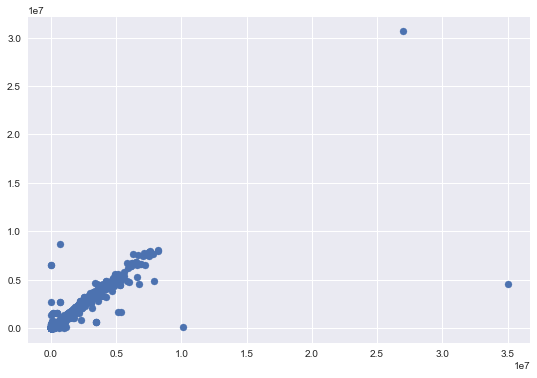

In [70]:
fig = plt.figure(figsize=(9,6))
plt.scatter(df['reported_annual_energy_prod'], df['annual_PV_prod'])

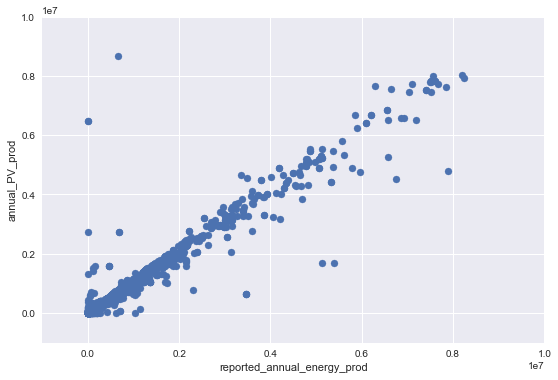

In [16]:
# limiting this a bit.

# There are far more missing values on reported than the other, so considering the similarities
# it seems fine to just go with annual_pv.

fig= plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(df['reported_annual_energy_prod'], df['annual_PV_prod'])
ax.set_xlim(-1000000,10000000)
ax.set_ylim(-1000000,10000000)
ax.set_xlabel("reported_annual_energy_prod")
ax.set_ylabel("annual_PV_prod")

# Insolation with Cost_per_Watt

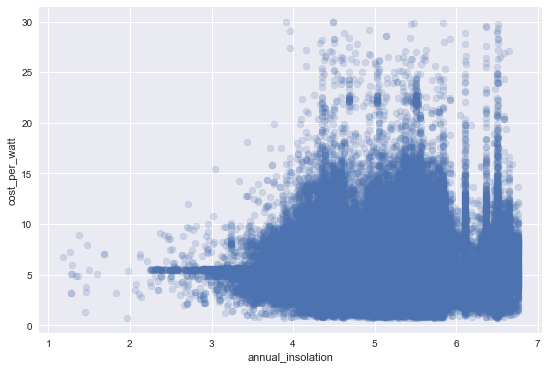

In [19]:
fig= plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(df['annual_insolation'], df['cost_per_watt'], alpha=0.2)
ax.set_xlabel("annual_insolation")
ax.set_ylabel("cost_per_watt")


my hypothesis here is that the more insolation, the cheaper the electricity.  It's hard to tell, but if anything
it looks like there's the opposite relationship

That being said, it's hard to get much from this.

# Correlations

In [27]:
# let's just look at the correlations with all of the numeric features, maybe something will pop out.
# I'm particuarly curious if there are any that correlate with cost_per_watt.

def correlation_heat_map(df):
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = (13, 8.5))
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    
    plt.show()

In [29]:
del(df['index'])
del(df['level_0'])

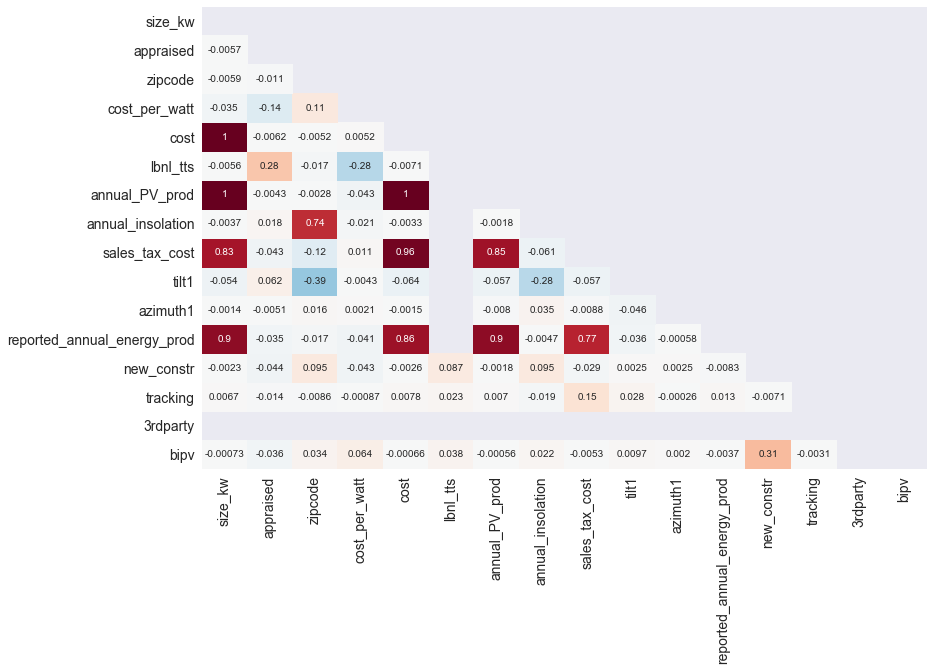

In [30]:
correlation_heat_map(df)

### Takeaways:

1. Size is directly correlated with sales tax, amount of energy and cost, which of course makes sense.
2. There's a slight negative correlation with appraised and cost per watt, which indicates that perhaps being appraised yields cheaper energy.
3. This is a little silly, but we see a very slight positive correlation with zipcode and cost_per_watt.  Higher zipcodes are generally on the west coast, so maybe there's more expensive energy on the west coast.  Will want to include geographic variables in the final model.
4. There really ISN'T an obvious connection between cost_per_watt and insolation, which is one of my main thoughts going into this.  The insolation data in this data set isn't as granular as what I'm gathering, so it'll be interesting to see what we get with that data.